In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from scheduler import OneCyclePolicy

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import numpy as np

Download dataset and calculate mean, std

In [2]:
# dataset = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transforms.ToTensor(), download=True)
#
# mean = dataset.data.mean(axis=(0,1,2))/255
# std = dataset.data.std(axis=(0,1,2))/255
# image size = 32
# print(mean,std) #[0.50707516 0.48654887 0.44091784] [0.26733429 0.25643846 0.27615047]

In [3]:
def imshow(img):
    inv_trans = transforms.Normalize((-0.5071/0.2673, -0.4865/0.2564, -0.4409/0.2761), (1/0.2673, 1/0.2564, 1/0.2761))
    img = inv_trans(img) # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))])

train_set = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=1)

test_set = torchvision.datasets.CIFAR100(root='./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=1)

print(len(train_loader), len(test_loader))

782 157


In [5]:
train_set, valid_set = torch.utils.data.random_split(train_set, [40000, 10000])

print(len(train_set), len(valid_set))

40000 10000


In [6]:
torch.save(train_set,"./train_data.set")
torch.save(valid_set,"./valid_data.set")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


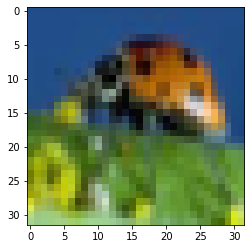

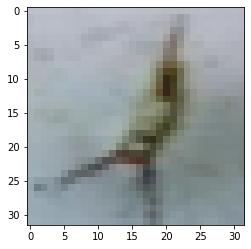

In [7]:
train_image, train_label = next(iter(train_set))
valid_image, valid_label = next(iter(valid_set))

imshow(train_image)
imshow(valid_image)

In [8]:
load_train_set = torch.load("./train_data.set")
load_valid_set = torch.load("./valid_data.set")


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
model = Net()
epochs = 200
# model = torchvision.models.resnet18()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1234)
one_cycle = OneCyclePolicy(optimizer,lr=1e-3,epochs=epochs*len(train_loader))
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
if torch.cuda.is_available():
    model.to('cuda')

# print(f"total params {total_params * 1e-3:.2f} K")

In [14]:
for epoch in tqdm(range(epochs),desc="main"):

    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader),total=len(train_loader),leave=False):

        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        one_cycle.step()

        running_loss += loss.item()

    print('[%d, %5d] loss: %.3f' %
          (epoch + 1, i + 1, running_loss / len(train_loader)))

    if (epoch+1) % 10==0:
        correct = 0
        with torch.no_grad():
            for i, data in enumerate(test_loader):
                inputs, labels = data
                inputs, labels = inputs.to('cuda'), labels.to('cuda')

                outputs = model(inputs)

                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

            print(f'[{epoch+1}] acc: {correct/len(test_set)}')

main:   0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[1,   782] loss: 2.916
[2,   782] loss: 2.519
[3,   782] loss: 2.183
[4,   782] loss: 1.867
[5,   782] loss: 1.571
[6,   782] loss: 1.287
[7,   782] loss: 1.049
[8,   782] loss: 0.850
[9,   782] loss: 0.712
[10,   782] loss: 0.637
[10] acc: 0.3317
[11,   782] loss: 0.571
[12,   782] loss: 0.539
[13,   782] loss: 0.536
[14,   782] loss: 0.497
[15,   782] loss: 0.474
[16,   782] loss: 0.481
[17,   782] loss: 0.461
[18,   782] loss: 0.451
[19,   782] loss: 0.441
[20,   782] loss: 0.441
[20] acc: 0.3393
[21,   782] loss: 0.421
[22,   782] loss: 0.408
[23,   782] loss: 0.398
[24,   782] loss: 0.418
[25,   782] loss: 0.402
[26,   782] loss: 0.385
[27,   782] loss: 0.373
[28,   782] loss: 0.373
[29,   782] loss: 0.346
[30,   782] loss: 0.367
[30] acc: 0.3426
[31,   782] loss: 0.358
[32,   782] loss: 0.333
[33,   782] loss: 0.340
[34,   782] loss: 0.326
[35,   782] loss: 0.313
[36,   782] loss: 0.324
[37,   782] loss: 0.292
[38,   782] loss: 0.313
[39,   782] loss: 0.297
[40,   782] loss: 0.28

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
def get_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    print(maxk)
    print(batch_size)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        wrong_k = batch_size - correct_k
        res.append(wrong_k.mul_(100.0 / batch_size))

    return res

In [30]:
correct = 0
total = len(test_set)
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, labels = data[0].to('cuda'), data[1].to('cuda')

        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)

        correct += (predicted == labels).sum().item()

        # top1 = get_accuracy(outputs,labels)
        output = outputs
        target = labels
        topk=(1,3)

        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        # print(correct)
        print(len(correct))
        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            wrong_k = batch_size - correct_k
            res.append(wrong_k.mul_(100.0 / batch_size))
        break

3


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [60]:
print(correct[:3].size())
correct_k = correct[:3].reshape(-1).float().sum(0,keepdim=True)
wrong_k = batch_size - correct_k
print(correct_k)
print(wrong_k)
print(wrong_k.mul_(100.0/batch_size))

torch.Size([2, 64])
tensor([1.], device='cuda:0')
tensor([63.], device='cuda:0')
tensor([98.4375], device='cuda:0')


In [68]:
# data = next(iter(test_loader))
with torch.no_grad():
    inputs, labels = data[0].to('cuda'), data[1].to('cuda')

    outputs = model(inputs)

    output = outputs
    target = labels
    topk=(1,2)

    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    print(pred)
    print(target.reshape(1,-1).expand_as(pred))
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    print(correct)

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        wrong_k = batch_size - correct_k
        res.append(wrong_k.mul_(100.0 / batch_size))

tensor([[14, 14, 14, 14, 14, 14, 75, 87, 75, 14, 14, 14, 14, 14, 14, 14, 14, 14,
         14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 75, 14, 87, 14, 87, 14, 14,
         14, 14, 14, 14, 14, 14, 75, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
         14, 87, 14, 14, 14, 14, 14, 14, 14, 14],
        [75, 75, 75, 75, 87, 75, 87, 75, 14, 75, 88, 75, 24, 75, 75, 75, 88, 75,
         75, 87, 75, 75, 36, 24, 87, 87, 75, 75, 75, 14, 75, 75, 36, 85, 75, 75,
         75, 75, 75, 87, 75, 87, 14, 75, 87, 87, 75, 88, 87, 75, 87, 75, 75, 87,
         75, 75, 75, 87, 87, 75, 75, 75, 75, 75]], device='cuda:0')
tensor([[49, 33, 72, 51, 71, 92, 15, 14, 23,  0, 71, 75, 81, 69, 40, 43, 92, 97,
         70, 53, 70, 49, 75, 29, 21, 16, 39,  8,  8, 70, 20, 61, 41, 93, 56, 73,
         58, 11, 25, 37, 63, 24, 49, 73, 56, 22, 41, 58, 75, 17,  4,  6,  9, 57,
          2, 32, 71, 52, 42, 69, 77, 27, 15, 65],
        [49, 33, 72, 51, 71, 92, 15, 14, 23,  0, 71, 75, 81, 69, 40, 43, 92, 97,
         70, 53, 70, 4